Epoch 1: Total=54.1640, Recon=54.0343, KL=162.1780
Epoch 2: Total=2.4361, Recon=2.1162, KL=399.8564
Epoch 3: Total=1.4960, Recon=1.1215, KL=468.2387
Epoch 4: Total=1.2067, Recon=0.8031, KL=504.4072
Epoch 5: Total=1.0550, Recon=0.6334, KL=527.0070
Epoch 6: Total=0.9561, Recon=0.5224, KL=542.0978
Epoch 7: Total=0.8882, Recon=0.4463, KL=552.3905
Epoch 8: Total=0.8446, Recon=0.3978, KL=558.5049
Epoch 9: Total=0.8085, Recon=0.3593, KL=561.4475
Epoch 10: Total=0.7791, Recon=0.3289, KL=562.6994
Epoch 11: Total=0.7508, Recon=0.3008, KL=562.5671
Epoch 12: Total=0.7340, Recon=0.2851, KL=561.1624
Epoch 13: Total=0.7133, Recon=0.2658, KL=559.4491
Epoch 14: Total=0.6959, Recon=0.2502, KL=557.0730
Epoch 15: Total=0.6817, Recon=0.2383, KL=554.2607
Epoch 16: Total=0.6705, Recon=0.2296, KL=551.1201
Epoch 17: Total=0.6546, Recon=0.2157, KL=548.6240
Epoch 18: Total=0.6451, Recon=0.2088, KL=545.4001
Epoch 19: Total=0.6355, Recon=0.2012, KL=542.8226
Epoch 20: Total=0.6247, Recon=0.1928, KL=539.8080


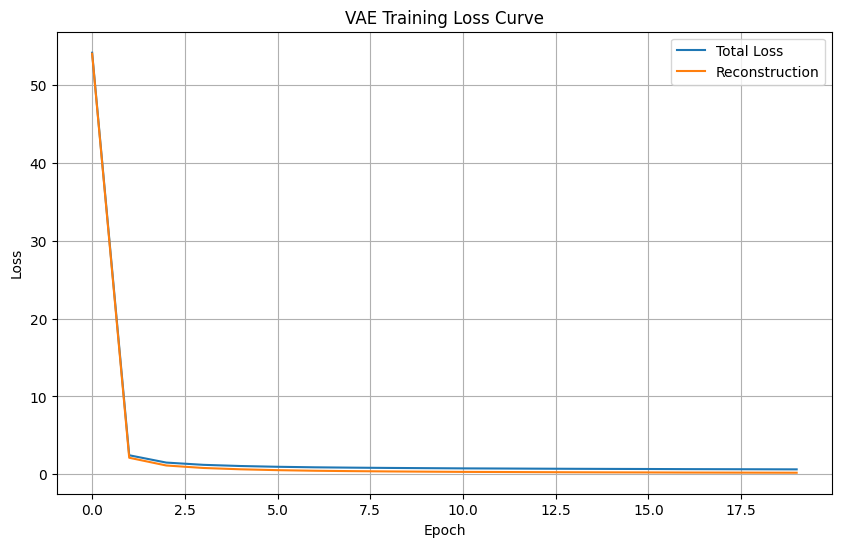

Shapiro-Wilk 正态性检验（前10个 latent 维度）
dim  0 | mean=+0.75, std=0.98 | Shapiro p=4.52e-35
dim  1 | mean=+0.68, std=1.13 | Shapiro p=1.86e-21
dim  2 | mean=-0.07, std=1.06 | Shapiro p=2.05e-11
dim  3 | mean=+0.11, std=1.17 | Shapiro p=7.27e-17
dim  4 | mean=+0.17, std=1.29 | Shapiro p=2.35e-08
dim  5 | mean=-0.97, std=0.99 | Shapiro p=3.17e-26
dim  6 | mean=-0.31, std=1.13 | Shapiro p=3.55e-14
dim  7 | mean=-0.76, std=1.03 | Shapiro p=6.18e-14
dim  8 | mean=-0.38, std=0.76 | Shapiro p=2.66e-50
dim  9 | mean=-0.05, std=1.22 | Shapiro p=2.71e-36


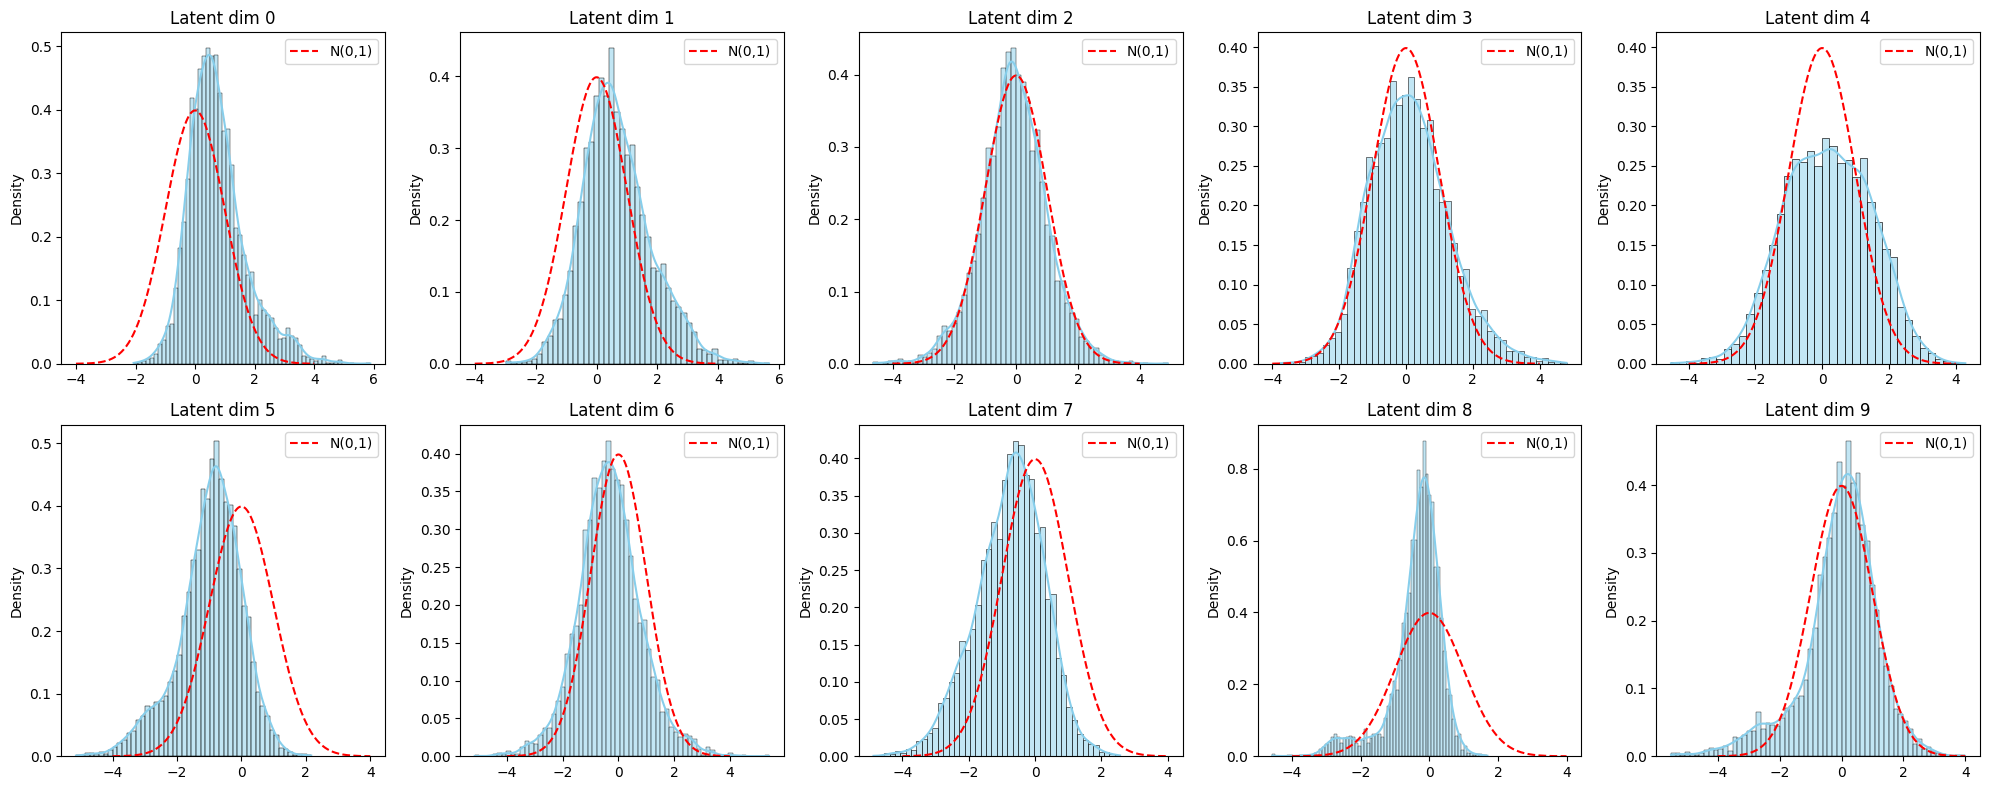

In [3]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro



SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



df = pd.read_csv("simulated_23_anomaly_dataset.csv")
feature_cols = ['age', 'duration', 'dupi',
                'output_1', 'output_2', 'output_3',
                'output_4', 'output_5', 'output_6']
X = df[feature_cols].values.astype(np.float32)

n_train = int(0.8 * len(X))
X_train, X_test = X[:n_train], X[n_train:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=128, shuffle=False)


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return self.fc2(h)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar



beta = 0.0008

input_dim = X_train.shape[1]
latent_dim = 20
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_fn(x, x_hat, mu, logvar, beta):
    recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

loss_list, recon_list, kl_list = [], [], []

vae.train()
for epoch in range(20):
    total_loss, total_recon, total_kl = 0, 0, 0
    for (x_batch,) in train_loader:
        x_hat, mu, logvar = vae(x_batch)
        loss, recon, kl = loss_fn(x_batch, x_hat, mu, logvar, beta=beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    loss_list.append(total_loss)
    recon_list.append(total_recon)
    kl_list.append(total_kl)
    print(f"Epoch {epoch+1}: Total={total_loss:.4f}, Recon={total_recon:.4f}, KL={total_kl:.4f}")


# 可视化 loss
plt.figure(figsize=(10,6))
plt.plot(loss_list, label='Total Loss')
plt.plot(recon_list, label='Reconstruction')
#plt.plot(kl_list, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
            

vae.eval()
mu_all = []
with torch.no_grad():
    for (x_batch,) in test_loader:
        _, mu, _ = vae(x_batch)
        mu_all.append(mu.numpy())
mu_all = np.vstack(mu_all)

# 绘图 + 正态性检测
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
print("Shapiro-Wilk 正态性检验（前10个 latent 维度）")
for i in range(10):
    ax = axes[i//5][i%5]
    z = mu_all[:, i]
    sns.histplot(z, kde=True, stat="density", ax=ax, color="skyblue")
    x_vals = np.linspace(-4, 4, 200)
    ax.plot(x_vals, 1/np.sqrt(2*np.pi)*np.exp(-x_vals**2/2), 'r--', label="N(0,1)")
    ax.set_title(f"Latent dim {i}")
    ax.legend()
    stat, pval = shapiro(z[:5000])
    print(f"dim {i:2d} | mean={np.mean(z):+.2f}, std={np.std(z):.2f} | Shapiro p={pval:.3g}")
plt.tight_layout()
plt.show()


In [4]:
# # === 1. 重建误差 MSE ===
# mse = np.mean((recon - true) ** 2, axis=1)
# plt.hist(mse, bins=100)
# plt.title("Anomaly Score (MSE)")
# plt.xlabel("MSE")
# plt.ylabel("Frequency")
# plt.show()

# # === 2. Z-score 计算 ===
# zscore = np.abs((true - recon) / (np.std(true, axis=0) + 1e-6))
# zscore_mean = np.mean(zscore, axis=1)
# plt.hist(zscore_mean, bins=100)
# plt.title("Z-score-based Anomaly Score")
# plt.xlabel("Average Z-score")
# plt.ylabel("Frequency")
# plt.show()

In [5]:
# Step 1: 计算测试集每个样本的重建误差（MSE）
vae.eval()
recon_errors = []
with torch.no_grad():
    for (x_batch,) in test_loader:
        x_hat, _, _ = vae(x_batch)
        mse_batch = nn.functional.mse_loss(x_hat, x_batch, reduction='none')
        batch_errors = mse_batch.mean(dim=1)  # 每个样本一行，取均值
        recon_errors.extend(batch_errors.numpy())

recon_errors = np.array(recon_errors)

# Step 2: 计算 z-score 分数
mean_err = recon_errors.mean()
std_err = recon_errors.std()
z_scores = (recon_errors - mean_err) / std_err

# Step 3: 添加到原始 DataFrame（只对测试集部分）
df_test = df.iloc[n_train:].copy()
df_test["recon_error"] = recon_errors
df_test["z_score"] = z_scores

Top 10% 异常样本数量: 460
        z_score  recon_error  age  duration  dupi  output_1  output_2  \
18403  1.354767     0.002571   42      2563  1689        40        41   
18407  1.088844     0.002327   22     -3094  1782        34        19   
18411  3.855855     0.004869   19      3067  2576        42        36   
18416  2.115005     0.003270   87      2636  4031        41        28   
18435  2.060675     0.003220   75      2707   608        55        32   
...         ...          ...  ...       ...   ...       ...       ...   
22927  2.277661     0.003419   41      2657  1094        45        27   
22950  1.444652     0.002654   48      2900  1095        45        33   
22966  1.118309     0.002354   72      3008  2787        57        38   
22974  2.822984     0.003920   20      3093  2591        37        40   
22982  2.217423     0.003364   48      2622    79        45        35   

       output_3  output_4  output_5  output_6  
18403        83        96         7        -1  
18407  

/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/ad2025/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998

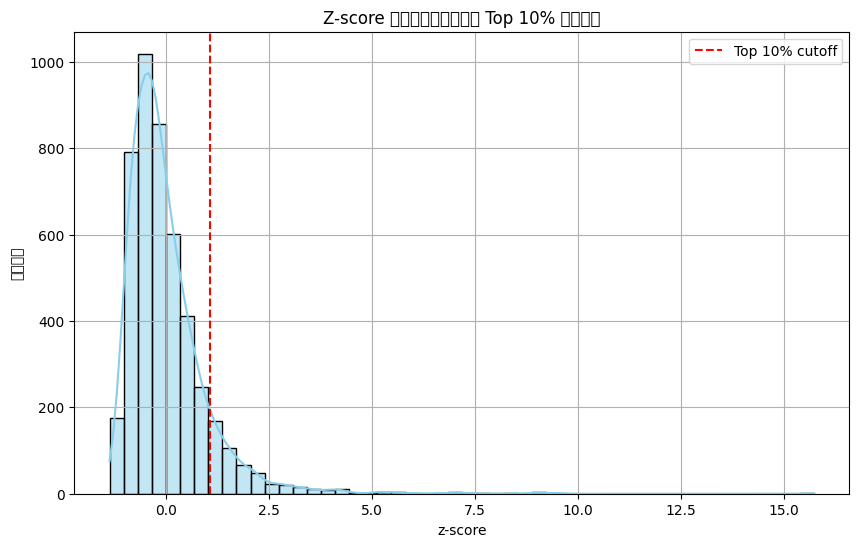

In [9]:
# 计算 z-score 排名前10%的样本数量
top_10pct_threshold = np.percentile(df_test["z_score"], 90)
top10pct_df = df_test[df_test["z_score"] >= top_10pct_threshold]

print(f"Top 10% 异常样本数量: {len(top10pct_df)}")
print(top10pct_df[["z_score", "recon_error"] + feature_cols])

plt.figure(figsize=(10, 6))
sns.histplot(df_test["z_score"], bins=50, kde=True, color="skyblue")

# 标出 top 10% 的 z-score 截断点
plt.axvline(top_10pct_threshold, color='red', linestyle='--', label='Top 10% cutoff')

plt.title("Z-score 分布（重建误差）及 Top 10% 异常样本")
plt.xlabel("z-score")
plt.ylabel("样本数量")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 找到 top 10% 样本的索引（相对于整个 df 的行号）
top10pct_indices = top10pct_df.index.to_numpy()
print("Top 10% 异常样本在原始 DataFrame 中的索引：")
print(top10pct_indices)

Top 10% 异常样本在原始 DataFrame 中的索引：
[18403 18407 18411 18416 18435 18438 18469 18472 18481 18494 18510 18531
 18538 18541 18548 18552 18558 18560 18563 18574 18576 18583 18598 18612
 18622 18631 18638 18644 18652 18655 18675 18693 18695 18696 18720 18722
 18743 18751 18753 18773 18774 18787 18791 18792 18796 18813 18821 18826
 18831 18833 18834 18839 18880 18882 18892 18907 18911 18937 18958 18963
 18980 18990 18993 18996 18999 19014 19018 19020 19024 19039 19059 19064
 19066 19068 19074 19083 19095 19099 19102 19107 19108 19111 19112 19129
 19132 19143 19169 19170 19206 19220 19221 19235 19248 19250 19253 19268
 19282 19296 19322 19331 19345 19357 19366 19367 19378 19393 19396 19436
 19452 19454 19455 19469 19471 19480 19492 19510 19513 19516 19523 19531
 19532 19539 19548 19549 19550 19567 19623 19632 19663 19667 19675 19690
 19696 19705 19728 19742 19749 19753 19754 19789 19795 19820 19828 19835
 19853 19879 19883 19891 19893 19913 19931 19939 19952 19958 19966 19970
 20006 20008 20011 

In [11]:
print(df.loc[top10pct_indices, ["initial_date", "final_date"]])

      initial_date  final_date
18403   2020-03-12  2017-11-28
18407   2022-04-15  2019-08-23
18411   2019-01-17  2017-10-14
18416   2021-06-24  2019-10-30
18435   2020-12-06  2018-11-11
...            ...         ...
22927   2019-11-05  2018-07-02
22950   2022-07-12  2018-02-02
22966   2020-01-31  2017-11-02
22974   2021-11-08  2019-04-05
22982   2019-01-23  2018-05-13

[460 rows x 2 columns]


In [12]:
# 将 initial_date 和 final_date 转换为 datetime 类型
df["initial_date"] = pd.to_datetime(df["initial_date"])
df["final_date"] = pd.to_datetime(df["final_date"])

In [13]:
# 提取 top 10% 样本的索引
top10pct_indices = top10pct_df.index.to_numpy()

# 提取月份信息
top10pct_months = df.loc[top10pct_indices, "initial_date"].dt.to_period("M")
month_counts = top10pct_months.value_counts().sort_index()

/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/2868652595.py:8: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/2868652595.py:8: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/2868652595.py:8: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/2868652595.py:8: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/2868652595.py:8: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52

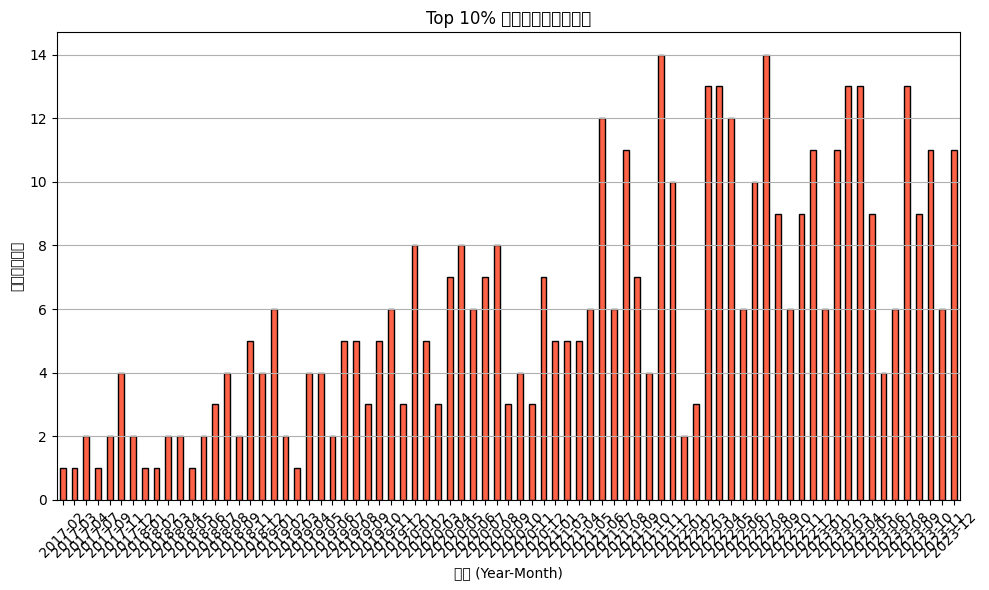

In [14]:
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color="tomato", edgecolor="black")
plt.title("Top 10% 异常样本的月份分布")
plt.xlabel("月份 (Year-Month)")
plt.ylabel("异常样本数量")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1625814643.py:18: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1625814643.py:18: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1625814643.py:18: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1625814643.py:18: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1625814643.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

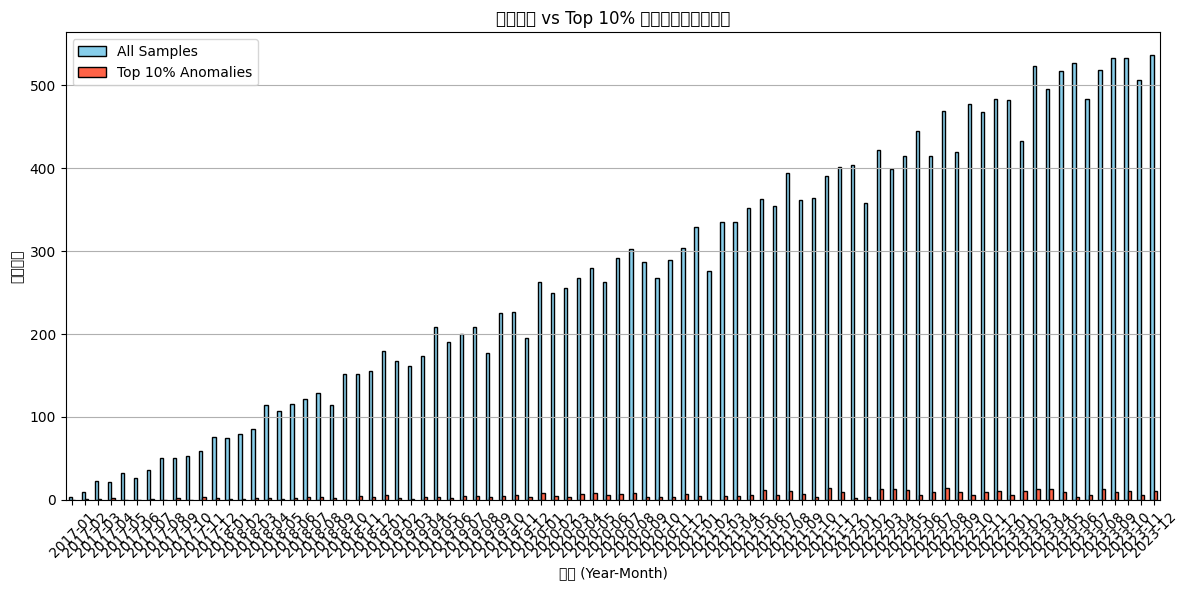

In [15]:
# 所有样本的月份分布
all_months = df["initial_date"].dt.to_period("M")
all_month_counts = all_months.value_counts().sort_index()

# 合并为一个 DataFrame
comparison_df = pd.DataFrame({
    "All Samples": all_month_counts,
    "Top 10% Anomalies": month_counts
}).fillna(0)

# 可视化
comparison_df.plot(kind='bar', figsize=(12, 6), color=["skyblue", "tomato"], edgecolor="black")
plt.title("所有样本 vs Top 10% 异常样本的月份分布")
plt.xlabel("月份 (Year-Month)")
plt.ylabel("样本数量")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1963997209.py:32: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1963997209.py:32: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1963997209.py:32: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1963997209.py:32: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/1963997209.py:32: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

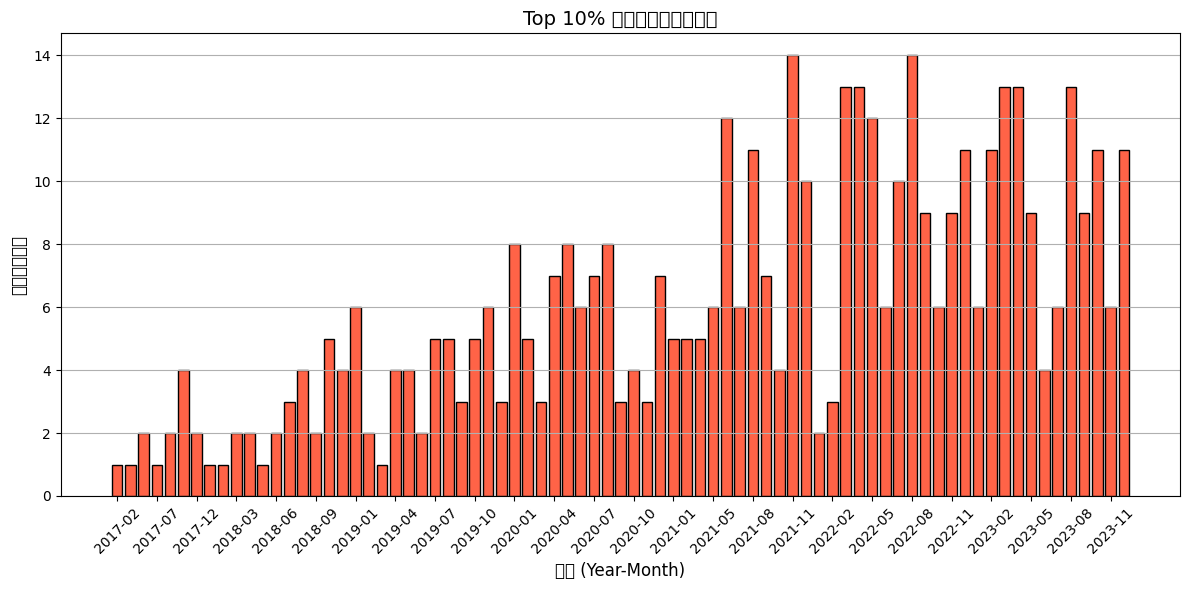

In [18]:
import matplotlib.pyplot as plt

# Step 1: 确保 initial_date 是 datetime 格式
df["initial_date"] = pd.to_datetime(df["initial_date"])

# Step 2: 提取 top 10% 样本的索引
top10pct_indices = top10pct_df.index.to_numpy()

# Step 3: 统计这些样本按月份的分布（按年月统计）
top10pct_months = df.loc[top10pct_indices, "initial_date"].dt.to_period("M")
month_counts = top10pct_months.value_counts().sort_index()

# Step 4: 画图，设置较大的 X 轴间距
plt.figure(figsize=(12, 6))
bars = plt.bar(month_counts.index.astype(str), month_counts.values, color="tomato", edgecolor="black")
plt.title("Top 10% 异常样本的月份分布", fontsize=14)
plt.xlabel("月份 (Year-Month)", fontsize=12)
plt.ylabel("异常样本数量", fontsize=12)

# 控制 x 轴刻度密度，比如只显示每隔 1~2 个标签
xtick_labels = month_counts.index.astype(str)
xtick_positions = np.arange(len(xtick_labels))



#plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)

skip = 3
plt.xticks(ticks=xtick_positions[::skip], labels=xtick_labels[::skip], rotation=45)


plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [19]:
print("Top 10% 异常样本的月份分布：")
print(month_counts)

Top 10% 异常样本的月份分布：
initial_date
2017-02     1
2017-03     1
2017-04     2
2017-07     1
2017-09     2
           ..
2023-08    13
2023-09     9
2023-10    11
2023-11     6
2023-12    11
Freq: M, Name: count, Length: 77, dtype: int64


/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/3794038056.py:23: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/3794038056.py:23: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/3794038056.py:23: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/3794038056.py:23: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7h1l52bvgckcytvzh5ws00000gn/T/ipykernel_30670/3794038056.py:23: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dj/6qv7

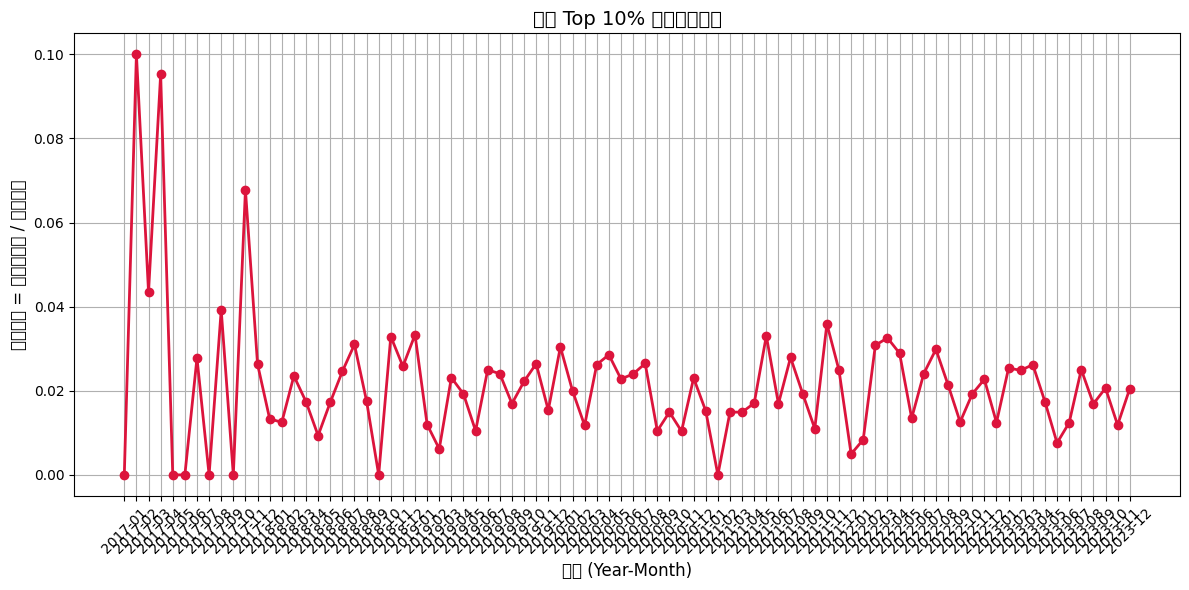

In [20]:
# Step 1: 所有样本的月份统计
all_months = df["initial_date"].dt.to_period("M")
all_month_counts = all_months.value_counts().sort_index()

# Step 2: Top 10% 异常样本的月份统计（已在之前完成）
top10pct_months = df.loc[top10pct_indices, "initial_date"].dt.to_period("M")
top10pct_counts = top10pct_months.value_counts().sort_index()

# Step 3: 对齐索引，并计算异常密度（避免 NaN）
all_month_counts = all_month_counts.sort_index()
top10pct_counts = top10pct_counts.reindex(all_month_counts.index, fill_value=0)

anomaly_density = top10pct_counts / all_month_counts

# Step 4: 可视化异常密度
plt.figure(figsize=(12, 6))
plt.plot(anomaly_density.index.astype(str), anomaly_density.values, marker='o', color='crimson', linewidth=2)
plt.title("每月 Top 10% 异常样本密度", fontsize=14)
plt.xlabel("月份 (Year-Month)", fontsize=12)
plt.ylabel("异常密度 = 异常样本数 / 总样本数", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# 合并到 DataFrame 输出
density_df = pd.DataFrame({
    "Total Samples": all_month_counts,
    "Top 10% Anomalies": top10pct_counts,
    "Anomaly Density": anomaly_density
})
print(density_df)

# 保存为 CSV
density_df.to_csv("monthly_anomaly_density.csv")

              Total Samples  Top 10% Anomalies  Anomaly Density
initial_date                                                   
2017-01                   4                  0         0.000000
2017-02                  10                  1         0.100000
2017-03                  23                  1         0.043478
2017-04                  21                  2         0.095238
2017-05                  32                  0         0.000000
...                     ...                ...              ...
2023-08                 519                 13         0.025048
2023-09                 533                  9         0.016886
2023-10                 533                 11         0.020638
2023-11                 506                  6         0.011858
2023-12                 537                 11         0.020484

[84 rows x 3 columns]
